In [4]:
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from scipy.stats import iqr

def get_bootstrap(data1, data2, iterations=1000, sign_level=0.05):
    mean_diff = np.median(data1) - np.median(data2)
    boot_data = []

    # Bootstrap sampling
    for i in range(iterations):
        curr_idxs1 = np.random.choice(len(data1), len(data1))
        curr_idxs2 = np.random.choice(len(data2), len(data2))
        boot_data.append(np.median(data1[curr_idxs1]) - np.median(data2[curr_idxs2]))
    
    boot_data = np.array(boot_data) - mean_diff
    # Calculate p-values
    p_value = sum(np.abs(boot_data) >= np.abs(mean_diff)) / len(boot_data)
    # print(mean_diff, boot_data)
    print(p_value)
    print(p_value > sign_level)
    
def get_bootstrap_IQR(data1, data2, iterations=1000, sign_level=0.05):
    mean_diff = iqr(data1) - iqr(data2)
    boot_data = []

    # Bootstrap sampling
    for i in range(iterations):
        curr_idxs1 = np.random.choice(len(data1), len(data1))
        curr_idxs2 = np.random.choice(len(data2), len(data2))
        boot_data.append(iqr(data1[curr_idxs1]) - iqr(data2[curr_idxs2]))
    
    boot_data = np.array(boot_data) - mean_diff
    # Calculate p-values
    p_value = sum(np.abs(boot_data) >= np.abs(mean_diff)) / len(boot_data)
    # print(mean_diff, boot_data)
    print(p_value)
    print(p_value > sign_level)
    
    
    
test_years = []
start_years = []
random_seeds = []
Cs = []

dict_b = {}
dict_r = {}
dict_p = {}
dict_t = {}
dict_b_auroc = {}
dict_r_auroc = {}
            

with open('hyptunelung.txt') as f:
    for line in f:
        if line.split(', ')[0].split(':')[0] == 'random_seed':
            curr_random_seed = int(line.split(', ')[0].split(':')[1])
            curr_start_year = int(line.split(', ')[1].split(':')[1])
            curr_test_year = int(line.split(', ')[2].split(':')[1])
            curr_C = float(line.split(', ')[3].split(':')[1].split('\n')[0])
            
            start_years.append(curr_start_year)
            test_years.append(curr_test_year)
            random_seeds.append(curr_random_seed)
            Cs.append(curr_C)
            
        elif line.split(':')[0] == 'BLOCK':
            dict_b[(curr_test_year, curr_start_year, curr_random_seed, curr_C)] = float(line.split(':')[1].split('\n')[0])
        elif line.split(':')[0] == 'RAND':
            dict_r[(curr_test_year, curr_start_year, curr_random_seed, curr_C)] = float(line.split(':')[1].split('\n')[0])
        elif line.split(':')[0] == 'PROP':
            dict_p[(curr_test_year, curr_start_year, curr_random_seed, curr_C)] = abs(float(line.split(':')[1].split('\n')[0]))
        elif line.split(':')[0] == 'TEST':
            dict_t[(curr_test_year, curr_start_year, curr_random_seed, curr_C)] = float(line.split(':')[1].split('\n')[0])


with open('hyptune_AUROC_lung.txt') as f:
    for line in f:
        if line.split(', ')[0].split(':')[0] == 'random_seed':
            curr_random_seed = int(line.split(', ')[0].split(':')[1])
            curr_start_year = int(line.split(', ')[1].split(':')[1])
            curr_C = float(line.split(', ')[3].split(':')[1].split('\n')[0])
        elif line.split(':')[0] == 'BLOCK':
            dict_b_auroc[(curr_start_year, curr_random_seed, curr_C)] = float(line.split(':')[1].split('\n')[0])
        elif line.split(':')[0] == 'RAND':
            dict_r_auroc[(curr_start_year, curr_random_seed, curr_C)] = float(line.split(':')[1].split('\n')[0])



start_years = list(set(start_years))
start_years.sort()

test_years = list(set(test_years))
test_years.sort()

random_seeds = list(set(random_seeds))
random_seeds.sort()


In [5]:
unique_b_C = []
unique_r_C = []
unique_p_C = []
test_year = 2000
for start_year in start_years:
    for seed in random_seeds:
        b_min_C = -1
        b_min_loss = 1000

        p_min_C = -1
        p_min_loss = 1000

        r_min_C = -1
        r_min_loss = 1000

        for c in Cs:
            if dict_b_auroc[(start_year, seed, c)] > 0.5:
                if abs(dict_p[(test_year, start_year, seed, c)]) < p_min_loss:
                    p_min_C = c
                    p_min_loss = dict_p[(test_year, start_year, seed, c)]
                if abs(dict_p[(test_year, start_year, seed, c)]) == p_min_loss:
                    if dict_b_auroc[(start_year, seed, c)]  > dict_b_auroc[(start_year, seed, p_min_C)]:
                        p_min_C = c
                        p_min_loss = dict_p[(test_year, start_year, seed, c)]

            if dict_b[(test_year, start_year, seed, c)] < b_min_loss:
                b_min_C = c
                b_min_loss = dict_b[(test_year, start_year, seed, c)]

            if dict_r[(test_year, start_year, seed, c)] < r_min_loss:
                r_min_C = c
                r_min_loss = dict_b[(test_year, start_year, seed, c)]

        # print(start_year, seed, b_min_C, r_min_C, p_min_C)
        unique_b_C.append(b_min_C)
        unique_r_C.append(r_min_C)
        unique_p_C.append(p_min_C)
print(list(set(unique_b_C)))
print(list(set(unique_r_C)))
print(list(set(unique_p_C)))

[1.0, 100.0]
[100000.0, 1.0, 100.0]
[100000.0, 1.0, 0.1, 100.0, 0.01, 10000.0, 0.001]


In [6]:
dict_b_auroc

{(1990, 0, 100000.0): 0.868318,
 (1990, 0, 10000.0): 0.868319,
 (1990, 0, 1000.0): 0.868318,
 (1990, 0, 100.0): 0.868318,
 (1990, 0, 1.0): 0.86827,
 (1990, 0, 0.1): 0.866893,
 (1990, 0, 0.01): 0.862033,
 (1990, 0, 0.001): 0.820047,
 (1990, 0, 0.0001): 0.5,
 (1990, 0, 1e-05): 0.5,
 (1991, 0, 100000.0): 0.868913,
 (1991, 0, 10000.0): 0.868913,
 (1991, 0, 1000.0): 0.868913,
 (1991, 0, 100.0): 0.868913,
 (1991, 0, 1.0): 0.868845,
 (1991, 0, 0.1): 0.867664,
 (1991, 0, 0.01): 0.863238,
 (1991, 0, 0.001): 0.820453,
 (1991, 0, 0.0001): 0.5,
 (1991, 0, 1e-05): 0.5,
 (1992, 0, 100000.0): 0.86808,
 (1992, 0, 10000.0): 0.86808,
 (1992, 0, 1000.0): 0.86808,
 (1992, 0, 100.0): 0.86808,
 (1992, 0, 1.0): 0.868051,
 (1992, 0, 0.1): 0.866808,
 (1992, 0, 0.01): 0.862445,
 (1992, 0, 0.001): 0.818796,
 (1992, 0, 0.0001): 0.5,
 (1992, 0, 1e-05): 0.5,
 (1993, 0, 100000.0): 0.868091,
 (1993, 0, 10000.0): 0.868091,
 (1993, 0, 1000.0): 0.868091,
 (1993, 0, 100.0): 0.868091,
 (1993, 0, 1.0): 0.867981,
 (1993, 0,

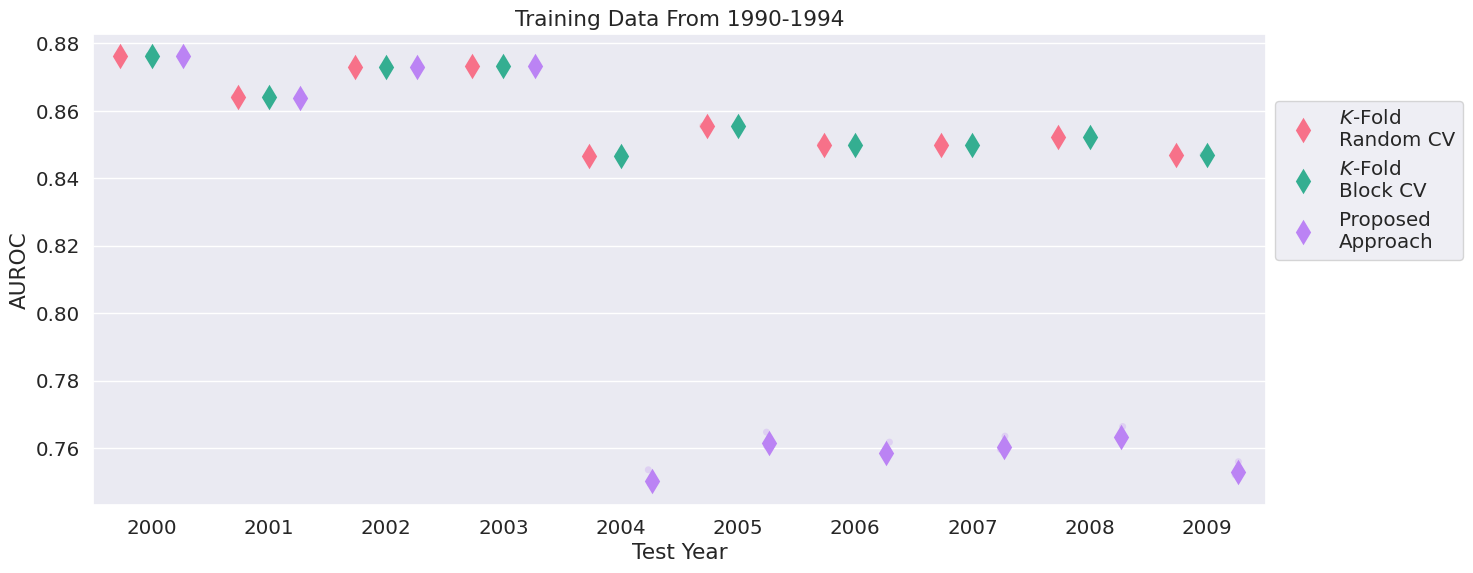

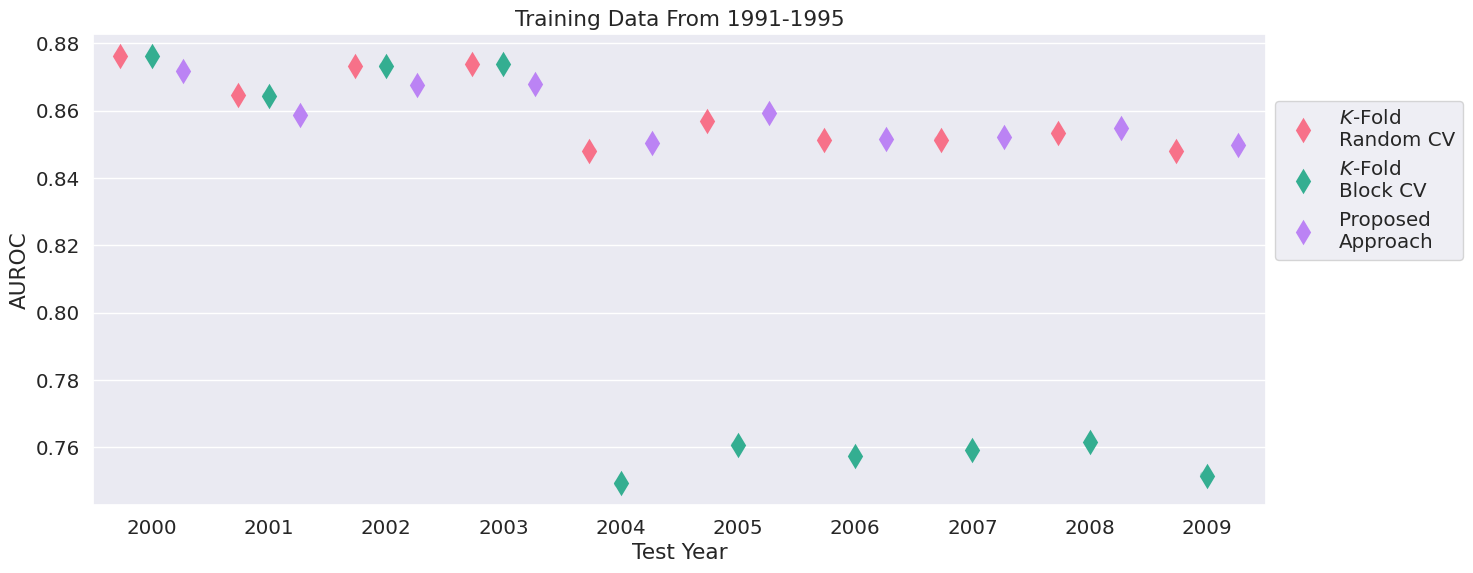

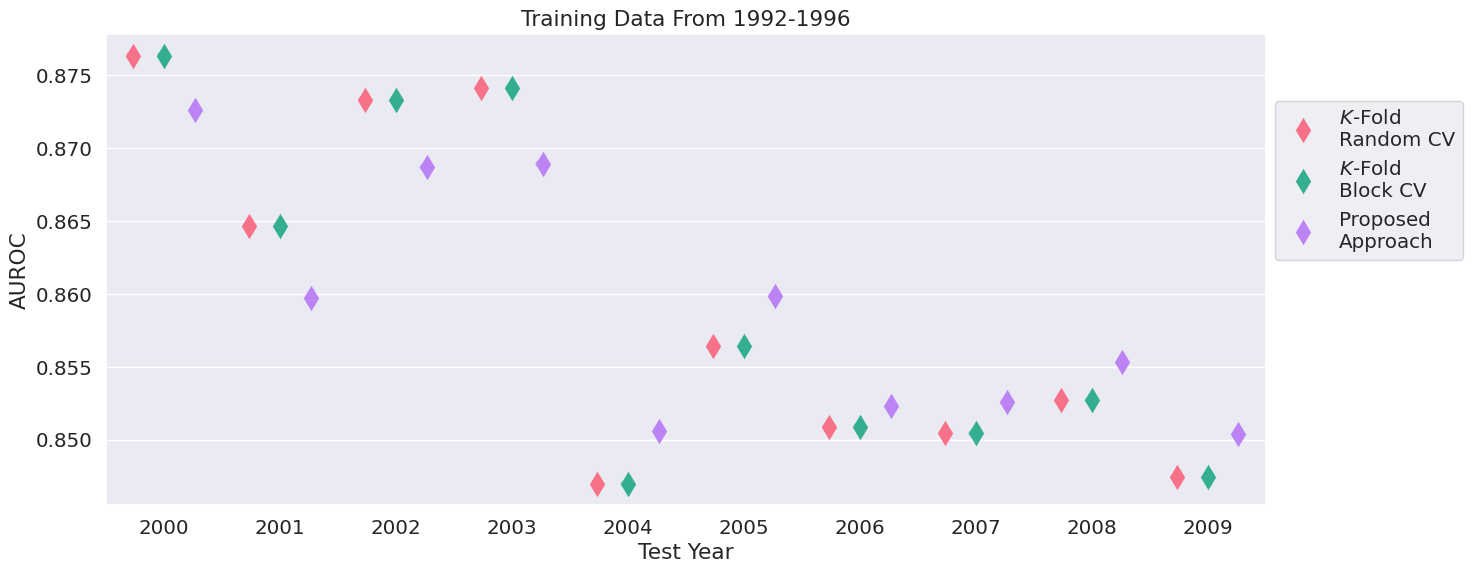

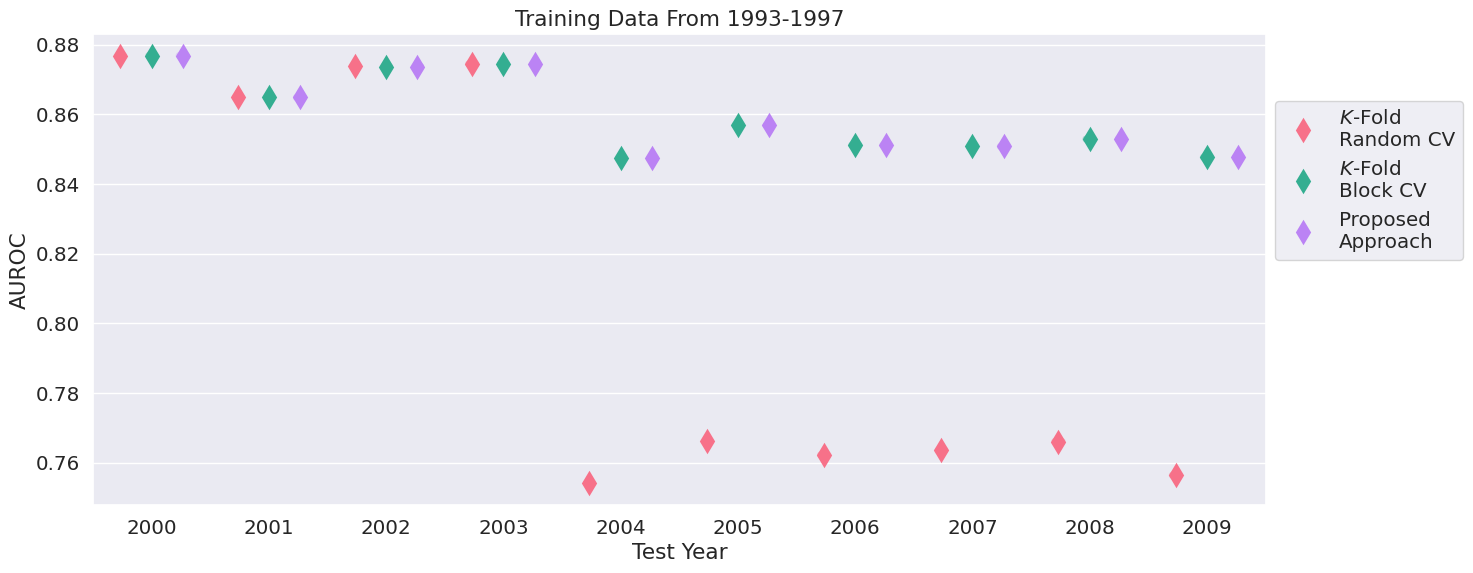

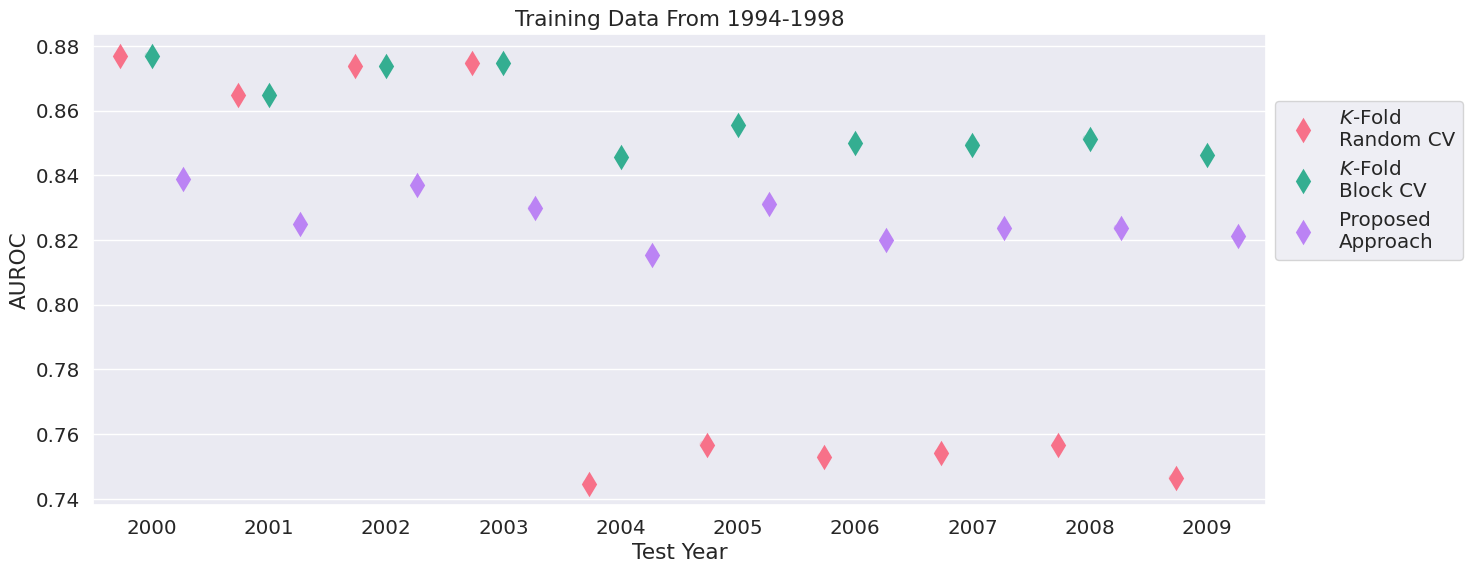

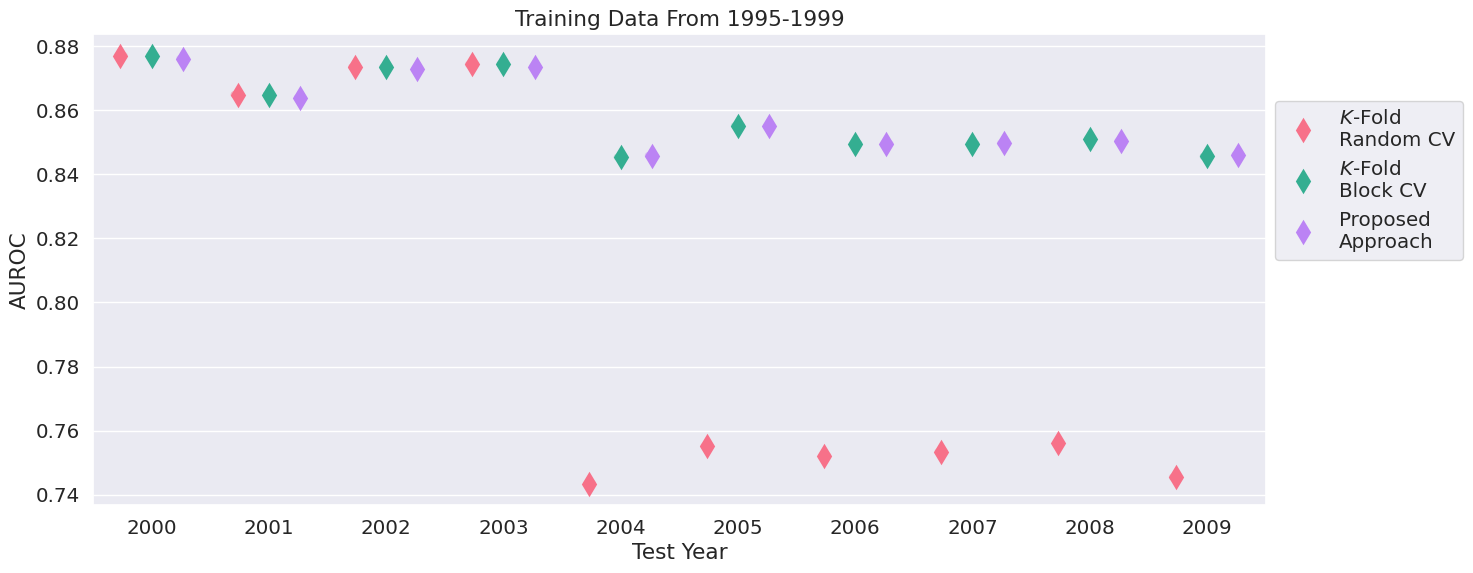

In [7]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.lines as mlines
sns.set(font_scale=1.3)

palette=[sns.color_palette("husl", 9)[0], sns.color_palette("husl", 9)[4], sns.color_palette("husl", 9)[7]]
count = -1

Cs = list(set(Cs))
Cs.sort(reverse = True)


cs = [1e5, 1e4, 1e3, 1e2, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
boot_size = 10

preds_test = joblib.load('dict_loss.joblib')

for start_year in start_years:
    count += 1
    dict_ = {}
    dict_['Method'] = []
    dict_['Test Year'] = []
    dict_['Negative Log Loss'] = []
    dict_['AUROC'] = []

    for test_year in test_years:  
        for seed in random_seeds:
            b_min_C = -1
            b_min_loss = 1000
            
            p_min_C = -1
            p_min_loss = 1000
            
            r_min_C = -1
            r_min_loss = 1000
            
            for c in Cs:
                if dict_b_auroc[(start_year, seed, c)] > 0.5:
                    if abs(dict_p[(test_year, start_year, seed, c)]) < p_min_loss:
                        p_min_C = c
                        p_min_loss = dict_p[(test_year, start_year, seed, c)]
                    if abs(dict_p[(test_year, start_year, seed, c)]) == p_min_loss:
                        if dict_b_auroc[(start_year, seed, c)]  > dict_b_auroc[(start_year, seed, p_min_C)]:
                            p_min_C = c
                            p_min_loss = dict_p[(test_year, start_year, seed, c)]
                        
                if dict_b[(test_year, start_year, seed, c)] < b_min_loss:
                    b_min_C = c
                    b_min_loss = dict_b[(test_year, start_year, seed, c)]
                        
                if dict_r[(test_year, start_year, seed, c)] < r_min_loss:
                    r_min_C = c
                    r_min_loss = dict_b[(test_year, start_year, seed, c)]
                        
            pred_test, test_y = preds_test[(seed, start_year, r_min_C, test_year)]            
            dict_['Method'].append('$K$-Fold\nRandom CV')
            dict_['Test Year'].append(test_year)
            dict_['Negative Log Loss'].append(log_loss(test_y, pred_test))
            dict_['AUROC'].append(roc_auc_score(test_y, pred_test))

            pred_test, test_y = preds_test[(seed, start_year, b_min_C, test_year)]
            dict_['Method'].append('$K$-Fold\nBlock CV')
            dict_['Test Year'].append(test_year)
            dict_['Negative Log Loss'].append(log_loss(test_y, pred_test))
            dict_['AUROC'].append(roc_auc_score(test_y, pred_test))

            pred_test, test_y = preds_test[(seed, start_year, p_min_C, test_year)]
            dict_['Method'].append('Proposed\nApproach')
            dict_['Test Year'].append(test_year)
            dict_['Negative Log Loss'].append(log_loss(test_y, pred_test))
            dict_['AUROC'].append(roc_auc_score(test_y, pred_test))

    df = pd.DataFrame(dict_)   

    fig, axes = plt.subplots(figsize = (15, 6))
    g = sns.stripplot(
    data=df, x="Test Year", y="AUROC", hue="Method",
    dodge=True, alpha=.25, ax = axes, zorder=1, palette=[sns.color_palette("husl", 9)[0], sns.color_palette("husl", 9)[4], sns.color_palette("husl", 9)[7]],  legend=False)
# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
    g2 = sns.pointplot(
    data=df, x="Test Year", y="AUROC", hue="Method",
    dodge=.8 - .8 / 3, errorbar=None,
    markers="d", markersize=10, ax = axes, linestyle='none', palette=[sns.color_palette("husl", 9)[0], sns.color_palette("husl", 9)[4], sns.color_palette("husl", 9)[7]])

    # axes.legend([],[], frameon=False)

#     r = mlines.Line2D([], [], color=sns.color_palette("husl", 9)[0], ls = '', marker = 'o', label='K-Fold Random CV')
#     b = mlines.Line2D([], [], color=sns.color_palette("husl", 9)[4],  ls='', marker = 'o', label='K-Fold Block CV')
#     p = mlines.Line2D([], [], color=sns.color_palette("husl", 9)[7], marker='o', ls='', label='Proposed Approach')

#     legend = axes.legend(bbox_to_anchor=(1.7, 1.0), loc='upper right', handles = [r, b, p], labels=['K-Fold\nRandom CV', 'K-Fold\nBlock CV', 'Proposed\nApproach'], fontsize = 18)


    plt.title('Training Data From %d-%d'%(start_year, start_year + 4))  
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig('realdata_auroc_%d.png'%start_year)




In [8]:
raw_roc_aucs = []
for start_year in start_years:
    count += 1
    dict_ = {}
    dict_['Method'] = []
    dict_['Test Year'] = []
    dict_['Negative Log Loss'] = []
    dict_['AUROC'] = []

    for test_year in test_years:  
        for seed in random_seeds:
            b_min_C = -1
            b_min_loss = 1000
            
            p_min_C = -1
            p_min_loss = 1000
            
            r_min_C = -1
            r_min_loss = 1000
            
            for c in Cs:
                if abs(dict_p[(test_year, start_year, seed, c)]) < p_min_loss:
                    p_min_C = c
                    p_min_loss = dict_p[(test_year, start_year, seed, c)]
            
            pred_test, test_y = preds_test[(seed, start_year, p_min_C, test_year)]
            raw_roc_aucs.append(roc_auc_score(test_y, pred_test))

In [9]:
print(sum([i == 0.5 for i in raw_roc_aucs]))

120


In [10]:
print(len([i == 0.5 for i in raw_roc_aucs]))

300


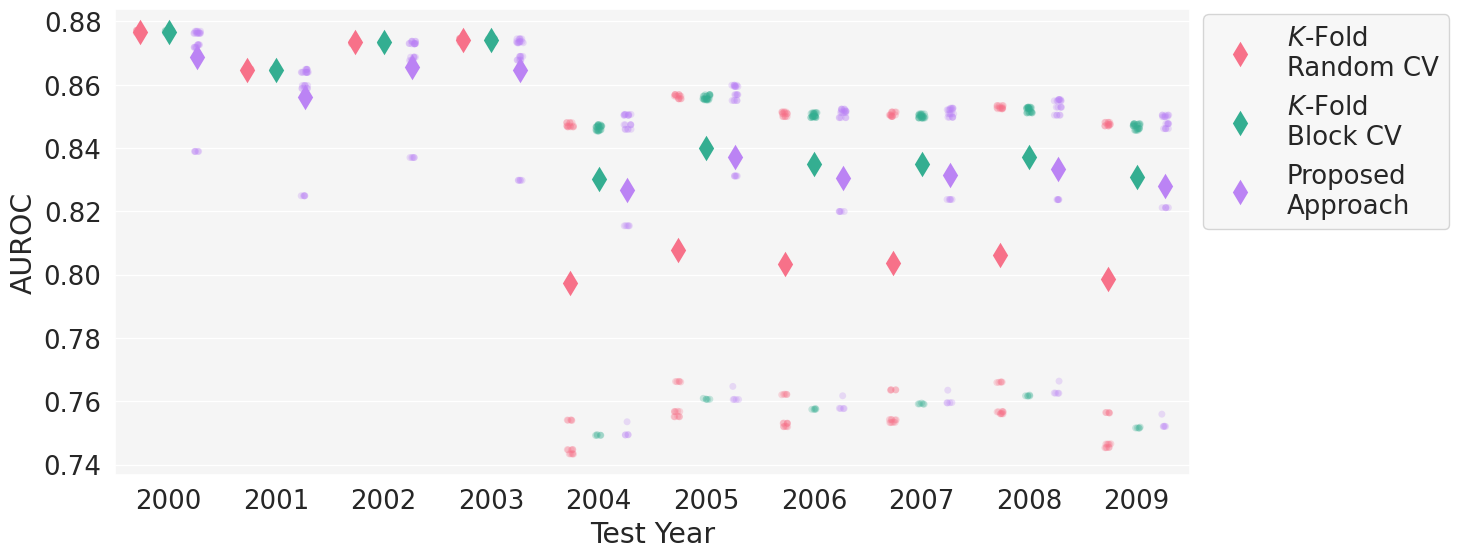

In [11]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.lines as mlines
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'white'}, font_scale=1.7)

palette=[sns.color_palette("husl", 9)[0], sns.color_palette("husl", 9)[4], sns.color_palette("husl", 9)[7]]
count = -1
    
start_years = list(set(start_years))
start_years.sort()

test_years = list(set(test_years))
test_years.sort()

random_seeds = list(set(random_seeds))
random_seeds.sort()

Cs = list(set(Cs))
Cs.sort(reverse = True)


cs = [1e5, 1e4, 1e3, 1e2, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

preds_test = joblib.load('dict_loss.joblib')

dict_ = {}
dict_['Method'] = []
dict_['Test Year'] = []
dict_['Negative Log Loss'] = []
dict_['AUROC'] = []

for start_year in start_years:
    count += 1

    for test_year in test_years:  
        for seed in random_seeds:
            b_min_C = -1
            b_min_loss = 1000
            
            p_min_C = -1
            p_min_loss = 1000
            
            r_min_C = -1
            r_min_loss = 1000
            
            for c in Cs:
                if dict_b_auroc[(start_year, seed, c)] > 0.5:
                    if abs(dict_p[(test_year, start_year, seed, c)]) < p_min_loss:
                        p_min_C = c
                        p_min_loss = dict_p[(test_year, start_year, seed, c)]
                    if abs(dict_p[(test_year, start_year, seed, c)]) == p_min_loss:
                        if dict_b_auroc[(start_year, seed, c)]  > dict_b_auroc[(start_year, seed, p_min_C)]:
                            p_min_C = c
                            p_min_loss = dict_p[(test_year, start_year, seed, c)]
                        
                if dict_b[(test_year, start_year, seed, c)] < b_min_loss:
                    b_min_C = c
                    b_min_loss = dict_b[(test_year, start_year, seed, c)]
                        
                if dict_r[(test_year, start_year, seed, c)] < r_min_loss:
                    r_min_C = c
                    r_min_loss = dict_b[(test_year, start_year, seed, c)]
                        

            pred_test, test_y = preds_test[(seed, start_year, r_min_C, test_year)]            
            dict_['Method'].append('$K$-Fold\nRandom CV')
            dict_['Test Year'].append(test_year)
            dict_['Negative Log Loss'].append(log_loss(test_y, pred_test))
            dict_['AUROC'].append(roc_auc_score(test_y, pred_test))

            pred_test, test_y = preds_test[(seed, start_year, b_min_C, test_year)]
            dict_['Method'].append('$K$-Fold\nBlock CV')
            dict_['Test Year'].append(test_year)
            dict_['Negative Log Loss'].append(log_loss(test_y, pred_test))
            dict_['AUROC'].append(roc_auc_score(test_y, pred_test))

            pred_test, test_y = preds_test[(seed, start_year, p_min_C, test_year)]
            dict_['Method'].append('Proposed\nApproach')
            dict_['Test Year'].append(test_year)
            dict_['Negative Log Loss'].append(log_loss(test_y, pred_test))
            dict_['AUROC'].append(roc_auc_score(test_y, pred_test))

df = pd.DataFrame(dict_)   

fig, axes = plt.subplots(figsize = (15, 6))
g = sns.stripplot(
data=df, x="Test Year", y="AUROC", hue="Method",
dodge=True, alpha=.25, ax = axes, zorder=1, palette=[sns.color_palette("husl", 9)[0], sns.color_palette("husl", 9)[4], sns.color_palette("husl", 9)[7]],  legend=False)
# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
g2 = sns.pointplot(
data=df, x="Test Year", y="AUROC", hue="Method",
dodge=.8 - .8 / 3, errorbar=None,
markers="d", markersize=10, ax = axes, linestyle='none', palette=[sns.color_palette("husl", 9)[0], sns.color_palette("husl", 9)[4], sns.color_palette("husl", 9)[7]])

# axes.legend([],[], frameon=False)

#     r = mlines.Line2D([], [], color=sns.color_palette("husl", 9)[0], ls = '', marker = 'o', label='K-Fold Random CV')
#     b = mlines.Line2D([], [], color=sns.color_palette("husl", 9)[4],  ls='', marker = 'o', label='K-Fold Block CV')
#     p = mlines.Line2D([], [], color=sns.color_palette("husl", 9)[7], marker='o', ls='', label='Proposed Approach')

#     legend = axes.legend(bbox_to_anchor=(1.7, 1.0), loc='upper right', handles = [r, b, p], labels=['K-Fold\nRandom CV', 'K-Fold\nBlock CV', 'Proposed\nApproach'], fontsize = 18)


plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig('realdata_AUROC.png')




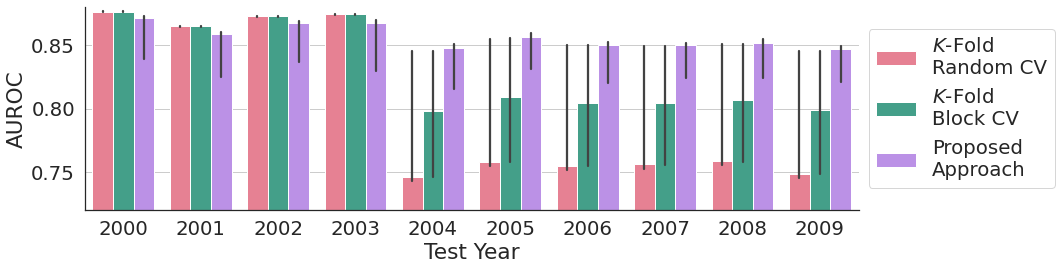

In [35]:
from matplotlib import rc
import matplotlib


sns.set(font_scale=1.8)
sns.set_style(style='white')

rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '.8',
      'font.size' : 15}
plt.rcParams.update(rc)

fig, axes = plt.subplots(figsize = (15, 4))
g = sns.barplot(
data=df, x="Test Year", y="AUROC", hue="Method",
dodge=True, ax = axes, zorder=1, estimator='median', errorbar=('pi', 50), palette=[sns.color_palette("husl", 9)[0], sns.color_palette("husl", 9)[4], sns.color_palette("husl", 9)[7]],  legend=True)
plt.ylim(0.72, 0.88)
sns.despine(bottom = False, left = False, top = True, right = True)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig('realdata_AUROC.png')




In [9]:
df_curr = df
rand_before = df_curr[df_curr['Method'] == '$K$-Fold\nRandom CV']['AUROC'].quantile([0.25, 0.5,0.75]).round(4)
block_before = df_curr[df_curr['Method'] == '$K$-Fold\nBlock CV']['AUROC'].quantile([0.25, 0.5,0.75]).round(4)
prop_before = df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].quantile([0.25, 0.5,0.75]).round(4)
text1 = '%0.3f, IQR: [%0.3f, %0.3f] vs. '%(prop_before[0.5], prop_before[0.25], prop_before[0.75])
text1 += '%0.3f, IQR: [%0.3f, %0.3f] and '%(rand_before[0.5], rand_before[0.25], rand_before[0.75])
text1 += '%0.3f, IQR: [%0.3f, %0.3f]'%(block_before[0.5], block_before[0.25], block_before[0.75])
print(text1)

get_bootstrap(df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].to_numpy(), df_curr[df_curr['Method'] == '$K$-Fold\nRandom CV']['AUROC'].to_numpy())
get_bootstrap(df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].to_numpy(), df_curr[df_curr['Method'] == '$K$-Fold\nBlock CV']['AUROC'].to_numpy())

0.851, IQR: [0.830, 0.860] vs. 0.850, IQR: [0.755, 0.873] and 0.851, IQR: [0.759, 0.873]
0.646
True
0.761
True


In [10]:
df_curr = df
get_bootstrap_IQR(df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].to_numpy(), df_curr[df_curr['Method'] == '$K$-Fold\nRandom CV']['AUROC'].to_numpy())
get_bootstrap_IQR(df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].to_numpy(), df_curr[df_curr['Method'] == '$K$-Fold\nBlock CV']['AUROC'].to_numpy())

0.0
False
0.016
False


In [11]:
df_curr = df[df['Test Year'] <= 2003]
rand_before = df_curr[df_curr['Method'] == '$K$-Fold\nRandom CV']['AUROC'].quantile([0.25, 0.5,0.75]).round(4)
block_before = df_curr[df_curr['Method'] == '$K$-Fold\nBlock CV']['AUROC'].quantile([0.25, 0.5,0.75]).round(4)
prop_before = df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].quantile([0.25, 0.5,0.75]).round(4)

In [12]:
text1 = '%0.3f, IQR: [%0.3f, %0.3f] vs.'%(prop_before[0.5], prop_before[0.25], prop_before[0.75])
text1 += '%0.3f, IQR: [%0.3f, %0.3f] and '%(rand_before[0.5], rand_before[0.25], rand_before[0.75])
text1 += '%0.3f, IQR: [%0.3f, %0.3f]'%(block_before[0.5], block_before[0.25], block_before[0.75])
print(text1)

0.864, IQR: [0.837, 0.871] vs.0.873, IQR: [0.871, 0.875] and 0.873, IQR: [0.871, 0.875]


In [13]:
df_curr = df[df['Test Year'] <= 2003]
get_bootstrap(df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].to_numpy(), df_curr[df_curr['Method'] == '$K$-Fold\nRandom CV']['AUROC'].to_numpy())
get_bootstrap(df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].to_numpy(), df_curr[df_curr['Method'] == '$K$-Fold\nBlock CV']['AUROC'].to_numpy())

0.003
False
0.0
False


In [14]:
df_curr = df[df['Test Year'] > 2003]
rand_after = df_curr[df_curr['Method'] == '$K$-Fold\nRandom CV']['AUROC'].quantile([0.25, 0.5,0.75]).round(4)
block_after = df_curr[df_curr['Method'] == '$K$-Fold\nBlock CV']['AUROC'].quantile([0.25, 0.5,0.75]).round(4)
prop_after = df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].quantile([0.25, 0.5,0.75]).round(4)

In [15]:
text1 = '%0.3f, IQR: [%0.3f, %0.3f] vs. '%(prop_after[0.5], prop_after[0.25], prop_after[0.75])
text1 += '%0.3f, IQR: [%0.3f, %0.3f] and'%(rand_after[0.5], rand_after[0.25], rand_after[0.75])
text1 += '%0.3f, IQR: [%0.3f, %0.3f]'%(block_after[0.5], block_after[0.25], block_after[0.75])
print(text1)

0.850, IQR: [0.824, 0.853] vs. 0.757, IQR: [0.749, 0.850] and0.804, IQR: [0.753, 0.850]


In [16]:
df_curr = df[df['Test Year'] > 2003]
get_bootstrap(df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].to_numpy(), df_curr[df_curr['Method'] == '$K$-Fold\nRandom CV']['AUROC'].to_numpy())
get_bootstrap(df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].to_numpy(), df_curr[df_curr['Method'] == '$K$-Fold\nBlock CV']['AUROC'].to_numpy())

0.0
False
0.007
False


In [17]:
df_curr = df[df['Test Year'] <= 2003]
df1 = df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].to_numpy()
df2 = df_curr[df_curr['Method'] == '$K$-Fold\nRandom CV']['AUROC'].to_numpy()
df3 = df_curr[df_curr['Method'] == '$K$-Fold\nBlock CV']['AUROC'].to_numpy()
med = max(np.median(abs(df1 - df2)), np.median(abs(df1 - df3)))
q1 = max(np.percentile(abs(df1 - df2), 25), np.percentile(abs(df1 - df3), 25))
q3 = max(np.percentile(abs(df1 - df2), 75), np.percentile(abs(df1 - df3), 75))

print('%0.3f, IQR: [%0.3f, %0.3f]'%(med, q1, q3))

diff_before = np.max(np.array([abs(df1 - df2), abs(df1 - df3)]), axis = 0)

0.005, IQR: [0.004, 0.037]


In [18]:
df_curr = df[df['Test Year'] > 2003]
df1 = df_curr[df_curr['Method'] == 'Proposed\nApproach']['AUROC'].to_numpy()
df2 = df_curr[df_curr['Method'] == '$K$-Fold\nRandom CV']['AUROC'].to_numpy()
df3 = df_curr[df_curr['Method'] == '$K$-Fold\nBlock CV']['AUROC'].to_numpy()
med = max(np.median(abs(df1 - df2)), np.median(abs(df1 - df3)))
q1 = max(np.percentile(abs(df1 - df2), 25), np.percentile(abs(df1 - df3), 25))
q3 = max(np.percentile(abs(df1 - df2), 75), np.percentile(abs(df1 - df3), 75))
print('%0.3f, IQR: [%0.3f, %0.3f]'%(med, q1, q3))

diff_after = np.max(np.array([abs(df1 - df2), abs(df1 - df3)]), axis = 0)

0.070, IQR: [0.006, 0.099]


In [19]:
get_bootstrap(diff_before, diff_after)


0.0
False


In [20]:
df

,Method,Test Year,Negative Log Loss,AUROC
0,$K$-Fold\nRandom CV,2000,0.266462,0.876089
1,$K$-Fold\nBlock CV,2000,0.266383,0.876177
2,Proposed\nApproach,2000,0.301421,0.837486
3,$K$-Fold\nRandom CV,2000,0.266463,0.876088
4,$K$-Fold\nBlock CV,2000,0.266383,0.876176
...,...,...,...,...
895,$K$-Fold\nBlock CV,2009,0.602717,0.845441
896,Proposed\nApproach,2009,0.511759,0.820723
897,$K$-Fold\nRandom CV,2009,0.602778,0.845441
898,$K$-Fold\nBlock CV,2009,0.602778,0.845441
